# Data Preprocessing — S&P 500 Financials
**Mục tiêu:** Làm sạch và chuẩn hóa dữ liệu tài chính của các công ty S&P 500 để sẵn sàng cho **phân cụm (clustering)**.

**Nội dung notebook:**
1) Cấu hình & import thư viện  
2) Đọc dữ liệu & chuẩn hóa tên cột  
3) Chuẩn hóa số: bỏ ký hiệu (`$`, `%`, `,`) & quy đổi hậu tố **K/M/B/T**  
4) Kiểm tra & xử lý thiếu dữ liệu  
5) Xử lý ngoại lệ (winsorize 1%–99%)  
6) Chuẩn hóa thang đo (RobustScaler)  
7) Feature engineering (52w_range, price_to_52w_high, valuation_z)  
8) Chọn tập biến cho mô hình & lưu kết quả

## 3.1. Cấu hình và nhập thư viện

In [13]:
# !pip install pandas numpy matplotlib scikit-learn

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler

pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

## 3.2. Đọc dữ liệu và chuẩn hóa tên cột
- Đổi tên về **snake_case** để dễ thao tác.
- Giữ lại cột định danh (`symbol`, `name`, `sector`, `sec_filings`).

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
SRC = r"/content/drive/MyDrive/financials.csv"
assert os.path.exists(SRC), "Không tìm thấy financials.csv"
df_raw = pd.read_csv(SRC)
df = df_raw.copy()

df.columns = (
    df.columns.str.strip()
              .str.lower()
              .str.replace(r"[^\w]+", "_", regex=True)
              .str.replace("__+", "_", regex=True)
              .str.strip("_")
)

print("Kích thước ban đầu:", df.shape)
df.head(5)

Kích thước ban đầu: (505, 14)


,symbol,name,sector,price,price_earnings,dividend_yield,earnings_share,52_week_low,52_week_high,market_cap,ebitda,price_sales,price_book,sec_filings
0,MMM,3M Company,Industrials,222.8900,24.3100,2.3329,7.9200,259.7700,175.4900,"138,721,055,226.0000","9,048,000,000.0000",4.3903,11.3400,http://www.sec.gov/cgi-bin/browse-edgar?action...
1,AOS,A.O. Smith Corp,Industrials,60.2400,27.7600,1.1480,1.7000,68.3900,48.9250,"10,783,419,933.0000","601,000,000.0000",3.5755,6.3500,http://www.sec.gov/cgi-bin/browse-edgar?action...
2,ABT,Abbott Laboratories,Health Care,56.2700,22.5100,1.9090,0.2600,64.6000,42.2800,"102,121,042,306.0000","5,744,000,000.0000",3.7405,3.1900,http://www.sec.gov/cgi-bin/browse-edgar?action...
3,ABBV,AbbVie Inc.,Health Care,108.4800,19.4100,2.4996,3.2900,125.8600,60.0500,"181,386,347,059.0000","10,310,000,000.0000",6.2916,26.1400,http://www.sec.gov/cgi-bin/browse-edgar?action...
4,ACN,Accenture plc,Information Technology,150.5100,25.4700,1.7145,5.4400,162.6000,114.8200,"98,765,855,553.0000","5,643,228,000.0000",2.6041,10.6200,http://www.sec.gov/cgi-bin/browse-edgar?action...


## 3.3. Chuẩn hóa dữ liệu số
**Mục tiêu:** Đồng nhất về kiểu `float64` để mô hình tính toán chính xác.

In [14]:
suffix_map = {"K": 1e3, "M": 1e6, "B": 1e9, "T": 1e12}

def to_num(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float, np.integer, np.floating)):
        return float(x)
    s = str(x).strip().replace("$","").replace("%","").replace(",","")
    m = re.match(r"^([-+]?\\d*\\.?\\d+)([KMBT])?$", s, flags=re.IGNORECASE)
    if m:
        val = float(m.group(1))
        suf = m.group(2)
        if suf: val *= suffix_map.get(suf.upper(), 1.0)
        return val
    try:
        return float(s)
    except:
        return np.nan

object_cols = [c for c in df.columns if df[c].dtype == "object"]
numeric_like = []
for c in object_cols:
    sample = df[c].dropna().astype(str).head(200).apply(to_num)
    if len(sample) and sample.notna().mean() >= 0.6:
        numeric_like.append(c)

print("Các cột object có khả năng là số:", numeric_like)

for c in numeric_like:
    df[c] = df[c].apply(to_num)

# Ép kiểu lại cho các cột số
for c in df.columns:
    if df[c].dtype != "object":
        df[c] = pd.to_numeric(df[c], errors="coerce")

df.head(5)

Các cột object có khả năng là số: []


,symbol,name,sector,price,price_earnings,dividend_yield,earnings_share,52_week_low,52_week_high,market_cap,ebitda,price_sales,price_book,sec_filings
0,MMM,3M Company,Industrials,222.8900,24.3100,2.3329,7.9200,259.7700,175.4900,"138,721,055,226.0000","9,048,000,000.0000",4.3903,11.3400,http://www.sec.gov/cgi-bin/browse-edgar?action...
1,AOS,A.O. Smith Corp,Industrials,60.2400,27.7600,1.1480,1.7000,68.3900,48.9250,"10,783,419,933.0000","601,000,000.0000",3.5755,6.3500,http://www.sec.gov/cgi-bin/browse-edgar?action...
2,ABT,Abbott Laboratories,Health Care,56.2700,22.5100,1.9090,0.2600,64.6000,42.2800,"102,121,042,306.0000","5,744,000,000.0000",3.7405,3.1900,http://www.sec.gov/cgi-bin/browse-edgar?action...
3,ABBV,AbbVie Inc.,Health Care,108.4800,19.4100,2.4996,3.2900,125.8600,60.0500,"181,386,347,059.0000","10,310,000,000.0000",6.2916,26.1400,http://www.sec.gov/cgi-bin/browse-edgar?action...
4,ACN,Accenture plc,Information Technology,150.5100,25.4700,1.7145,5.4400,162.6000,114.8200,"98,765,855,553.0000","5,643,228,000.0000",2.6041,10.6200,http://www.sec.gov/cgi-bin/browse-edgar?action...


## 3.4. Kiểm tra và xử lý dữ liệu thiếu
**Chính sách:** nếu missing >30% → drop cột; ngược lại → **median imputation**.

In [15]:
missing = (df.isna().mean()*100).round(2).sort_values(ascending=False)
display(missing.to_frame("Missing (%)").head(20))

high_miss_cols = missing[missing > 30].index.tolist()
df_clean = df.drop(columns=high_miss_cols, errors="ignore").copy()

num_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
for c in num_cols:
    df_clean[c] = df_clean[c].fillna(df_clean[c].median())

print("Kích thước sau xử lý thiếu:", df_clean.shape)
df_clean.head(3)

,Missing (%)
price_book,1.5800
price_earnings,0.4000
name,0.0000
sector,0.0000
price,0.0000
symbol,0.0000
dividend_yield,0.0000
earnings_share,0.0000
52_week_high,0.0000
52_week_low,0.0000


Kích thước sau xử lý thiếu: (505, 14)


,symbol,name,sector,price,price_earnings,dividend_yield,earnings_share,52_week_low,52_week_high,market_cap,ebitda,price_sales,price_book,sec_filings
0,MMM,3M Company,Industrials,222.8900,24.3100,2.3329,7.9200,259.7700,175.4900,"138,721,055,226.0000","9,048,000,000.0000",4.3903,11.3400,http://www.sec.gov/cgi-bin/browse-edgar?action...
1,AOS,A.O. Smith Corp,Industrials,60.2400,27.7600,1.1480,1.7000,68.3900,48.9250,"10,783,419,933.0000","601,000,000.0000",3.5755,6.3500,http://www.sec.gov/cgi-bin/browse-edgar?action...
2,ABT,Abbott Laboratories,Health Care,56.2700,22.5100,1.9090,0.2600,64.6000,42.2800,"102,121,042,306.0000","5,744,000,000.0000",3.7405,3.1900,http://www.sec.gov/cgi-bin/browse-edgar?action...


## 3.5. Xử lý dữ liệu ngoại lai (Winsorize 1%–99%)
Cắt đuôi phân phối để giảm ảnh hưởng extreme values trên mô hình dựa khoảng cách.

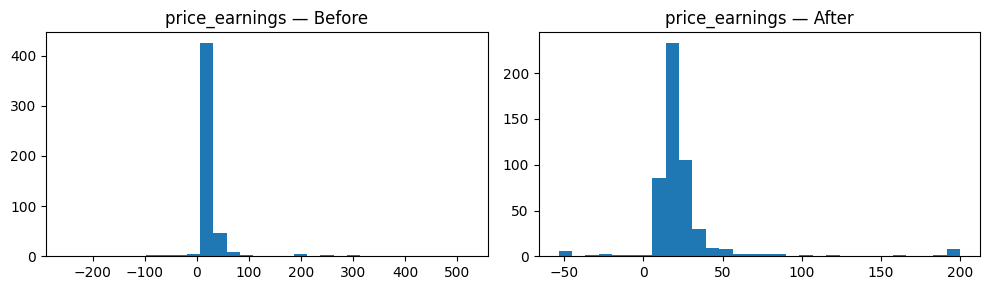

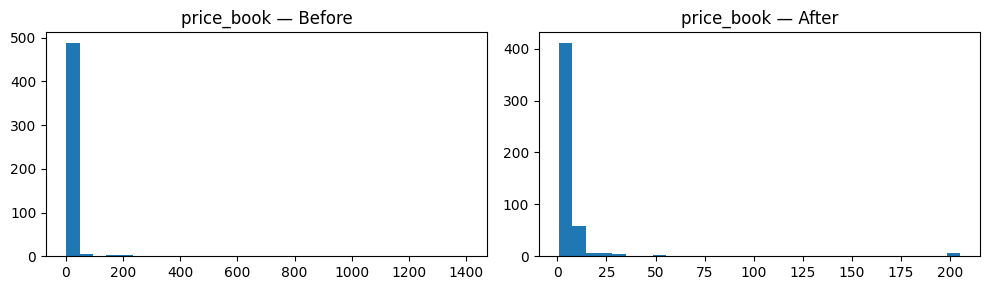

,symbol,name,sector,price,price_earnings,dividend_yield,earnings_share,52_week_low,52_week_high,market_cap,ebitda,price_sales,price_book,sec_filings
0,MMM,3M Company,Industrials,222.8900,24.3100,2.3329,7.9200,259.7700,175.4900,"138,721,055,226.0000","9,048,000,000.0000",4.3903,11.3400,http://www.sec.gov/cgi-bin/browse-edgar?action...
1,AOS,A.O. Smith Corp,Industrials,60.2400,27.7600,1.1480,1.7000,68.3900,48.9250,"10,783,419,933.0000","601,000,000.0000",3.5755,6.3500,http://www.sec.gov/cgi-bin/browse-edgar?action...
2,ABT,Abbott Laboratories,Health Care,56.2700,22.5100,1.9090,0.2600,64.6000,42.2800,"102,121,042,306.0000","5,744,000,000.0000",3.7405,3.1900,http://www.sec.gov/cgi-bin/browse-edgar?action...


In [16]:
def winsorize_percentile(s, lower=0.01, upper=0.99):
    lo, hi = s.quantile(lower), s.quantile(upper)
    return s.clip(lower=lo, upper=hi)

df_w = df_clean.copy()
for c in num_cols:
    df_w[c] = winsorize_percentile(df_w[c], 0.01, 0.99)

# QC nhanh: trước/sau cho 2 biến nếu có
qc_cols = [c for c in ["price_earnings","price_book","market_cap"] if c in num_cols][:2]
for col in qc_cols:
    fig = plt.figure(figsize=(10,3))
    plt.subplot(1,2,1); plt.hist(df_clean[col].dropna(), bins=30); plt.title(f"{col} — Before")
    plt.subplot(1,2,2); plt.hist(df_w[col].dropna(), bins=30); plt.title(f"{col} — After")
    plt.tight_layout(); plt.show()

df_w.head(3)

## 3.6. Chuẩn hóa thang đo (RobustScaler)
Tạo `X_scaled` để sử dụng cho bước **Clustering**.

In [17]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(df_w[num_cols]),
    columns=num_cols,
    index=df_w.index
)

df_scaled = df_w.copy()
for c in num_cols:
    df_scaled[c + "__scaled"] = X_scaled[c]

print("Shape X_scaled:", X_scaled.shape)
df_scaled.head(3)

Shape X_scaled: (505, 10)


,symbol,name,sector,price,price_earnings,dividend_yield,earnings_share,52_week_low,52_week_high,market_cap,...,price__scaled,price_earnings__scaled,dividend_yield__scaled,earnings_share__scaled,52_week_low__scaled,52_week_high__scaled,market_cap__scaled,ebitda__scaled,price_sales__scaled,price_book__scaled
0,MMM,3M Company,Industrials,222.8900,24.3100,2.3329,7.9200,259.7700,175.4900,"138,721,055,226.0000",...,2.1194,0.4678,0.2837,1.3781,2.0635,1.9344,3.6224,2.5468,0.4859,1.9900
1,AOS,A.O. Smith Corp,Industrials,60.2400,27.7600,1.1480,1.7000,68.3900,48.9250,"10,783,419,933.0000",...,-0.1946,0.7998,-0.3128,-0.3260,-0.2180,-0.2391,-0.3278,-0.3472,0.2209,0.7393
2,ABT,Abbott Laboratories,Health Care,56.2700,22.5100,1.9090,0.2600,64.6000,42.2800,"102,121,042,306.0000",...,-0.2511,0.2945,0.0703,-0.7205,-0.2632,-0.3533,2.4923,1.4148,0.2745,-0.0526


## 3.7. Tạo biến dẫn xuất (Feature engineering)

In [19]:
# 52w_range
if {"52_week_high","52_week_low"}.issubset(df_scaled.columns):
    # Mục tiêu: Đo lường biến động giá cổ phiếu trong 52 tuần, thể hiện sự ổn định của giá
    df_scaled["52w_range"] = (df_scaled["52_week_high"] - df_scaled["52_week_low"]) / df_scaled["52_week_low"].replace({0: np.nan})

# price_to_52w_high
if {"price","52_week_high"}.issubset(df_scaled.columns):
    # Mục tiêu: So sánh giá hiện tại với mức giá cao nhất trong 52 tuần, cho biết cổ phiếu đang ở đâu so với đỉnh gần nhất
    df_scaled["price_to_52w_high"] = df_scaled["price"] / df_scaled["52_week_high"].replace({0: np.nan})

# valuation_z: trung bình z robust của price_earnings, price_book, price_sales (nếu có >=2)
val_cols = [c for c in ["price_earnings","price_book","price_sales"] if c in df_scaled.columns]
if len(val_cols) >= 2:
    # Mục tiêu: Chuẩn hóa và kết hợp các chỉ số định giá để có cái nhìn tổng quát về sự đắt/rẻ của cổ phiếu
    z_df = pd.DataFrame(index=df_scaled.index)
    for c in val_cols:
        med = df_scaled[c].median()
        iqr = (df_scaled[c].quantile(0.75) - df_scaled[c].quantile(0.25)) or 1.0
        z_df[c] = (df_scaled[c] - med) / iqr
    df_scaled["valuation_z"] = z_df[val_cols].mean(axis=1)

# ebitda_log
if "ebitda" in df_scaled.columns:
    # Mục tiêu: Giảm skewness của biến EBITDA, làm cho phân phối gần với phân phối chuẩn hơn, giúp mô hình hoạt động tốt hơn
    # Thay thế giá trị không hợp lệ (âm hoặc 0) bằng một số dương nhỏ trước khi lấy log
    df_scaled["ebitda_log"] = np.log1p(df_scaled["ebitda"].clip(lower=1e-9))

# market_cap_log
if "market_cap" in df_scaled.columns:
    # Mục tiêu: Giảm skewness của biến market_cap, làm cho phân phối gần với phân phối chuẩn hơn, giúp mô hình hoạt động tốt hơn
     # Thay thế giá trị không hợp lệ (âm hoặc 0) bằng một số dương nhỏ trước khi lấy log
    df_scaled["market_cap_log"] = np.log1p(df_scaled["market_cap"].clip(lower=1e-9))


# profitability_ratio (ebitda / market_cap)
if {"ebitda","market_cap"}.issubset(df_scaled.columns):
    # Mục tiêu: Đo lường hiệu quả hoạt động dựa trên EBITDA so với quy mô công ty (market_cap)
    df_scaled["profitability_ratio"] = df_scaled["ebitda"] / df_scaled["market_cap"].replace({0: np.nan})

# dividend_flag
if "dividend_yield" in df_scaled.columns:
    # Mục tiêu: Tạo biến nhị phân (có/không) cho biết công ty có trả cổ tức hay không
    df_scaled["dividend_flag"] = (df_scaled["dividend_yield"] > 0).astype(int)


display(df_scaled.head(5))

,symbol,name,sector,price,price_earnings,dividend_yield,earnings_share,52_week_low,52_week_high,market_cap,...,ebitda__scaled,price_sales__scaled,price_book__scaled,52w_range,price_to_52w_high,valuation_z,ebitda_log,market_cap_log,profitability_ratio,dividend_flag
0,MMM,3M Company,Industrials,222.8900,24.3100,2.3329,7.9200,259.7700,175.4900,"138,721,055,226.0000",...,2.5468,0.4859,1.9900,-0.3244,1.2701,0.9812,22.9258,25.6557,0.0652,1
1,AOS,A.O. Smith Corp,Industrials,60.2400,27.7600,1.1480,1.7000,68.3900,48.9250,"10,783,419,933.0000",...,-0.3472,0.2209,0.7393,-0.2846,1.2313,0.5867,20.2141,23.1013,0.0557,1
2,ABT,Abbott Laboratories,Health Care,56.2700,22.5100,1.9090,0.2600,64.6000,42.2800,"102,121,042,306.0000",...,1.4148,0.2745,-0.0526,-0.3455,1.3309,0.1721,22.4714,25.3494,0.0562,1
3,ABBV,AbbVie Inc.,Health Care,108.4800,19.4100,2.4996,3.2900,125.8600,60.0500,"181,386,347,059.0000",...,2.9792,1.1043,5.6992,-0.5229,1.8065,2.2666,23.0564,25.9239,0.0568,1
4,ACN,Accenture plc,Information Technology,150.5100,25.4700,1.7145,5.4400,162.6000,114.8200,"98,765,855,553.0000",...,1.3803,-0.0951,1.8095,-0.2938,1.3108,0.7646,22.4537,25.3160,0.0571,1


## 3.8. Chọn tập biến & lưu kết quả

In [21]:
valuation = [c for c in ["price_earnings","price_book","price_sales","valuation_z"] if c in df_scaled.columns]
profitability = [c for c in ["earnings_share","dividend_yield","ebitda","ebitda_log","profitability_ratio"] if c in df_scaled.columns]
stability = [c for c in ["market_cap","price","52w_range","price_to_52w_high","market_cap_log"] if c in df_scaled.columns]
other_features = [c for c in ["dividend_flag"] if c in df_scaled.columns]


feature_candidates = valuation + profitability + stability + other_features
print("Feature candidates:", feature_candidates)

# Tạo ma trận đặc trưng đã scale
scaled_cols = []
for c in feature_candidates:
    if c in X_scaled.columns:
        scaled_cols.append(c)
    elif c + "__scaled" in df_scaled.columns:
        scaled_cols.append(c + "__scaled")
    elif c in ["52w_range","price_to_52w_high","valuation_z", "ebitda_log", "market_cap_log", "profitability_ratio", "dividend_flag"] and c in df_scaled.columns:
        # scale nhanh (robust) cho features mới
        med = df_scaled[c].median()
        iqr = (df_scaled[c].quantile(0.75) - df_scaled[c].quantile(0.25)) or 1.0
        df_scaled[c + "__scaled"] = (df_scaled[c] - med) / iqr
        scaled_cols.append(c + "__scaled")

X_features_scaled = df_scaled[scaled_cols].copy()
print("Shape features (scaled):", X_features_scaled.shape)

# Lưu output vào Google Drive
output_dir = "/content/drive/MyDrive/data/final_ktltpython" # Thay đổi đường dẫn thư mục lưu nếu cần
os.makedirs(output_dir, exist_ok=True) # Tạo thư mục nếu chưa tồn tại

clean_path = os.path.join(output_dir, "financials_clean.csv")
feat_path = os.path.join(output_dir, "financials_features_scaled.csv")

df_scaled.to_csv(clean_path, index=False)
X_features_scaled.to_csv(feat_path, index=False)

print("Đã lưu:")
print(" -", clean_path)
print(" -", feat_path)

Feature candidates: ['price_earnings', 'price_book', 'price_sales', 'valuation_z', 'earnings_share', 'dividend_yield', 'ebitda', 'ebitda_log', 'profitability_ratio', 'market_cap', 'price', '52w_range', 'price_to_52w_high', 'market_cap_log', 'dividend_flag']
Shape features (scaled): (505, 15)
Đã lưu:
 - /content/drive/MyDrive/data/final_ktltpython/financials_clean.csv
 - /content/drive/MyDrive/data/final_ktltpython/financials_features_scaled.csv
